# Visualize DLC results 

Load packages

In [ ]:
##### LOCAL or INTERACTIVE NODES #####

from ipyfilechooser import FileChooser
import os
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
from pathlib import Path
import re
from scipy.ndimage import median_filter
%matplotlib widget

Load .h5 file

In [ ]:
try:
    %store -r filename
    filename = os.path.dirname(filename)
except NameError:
    filename = "//10.69.168.1/crnldata/forgetting/Aurelie/"

fc1 = FileChooser(filename, select_default=True, show_only_dirs=False, title="<b>Choose .h5 file</b>", layout=widgets.Layout(width='100%'))
display(fc1)

def update_file(chooser):
    global filename
    if chooser.selected:
        filename = chooser.selected
        %store filename

fc1.register_callback(update_file)

FileChooser(path='\\10.69.168.1\crnldata\forgetting\Aurelie', filename='', title='<b>Choose .h5 file</b>', sho…

Process and plot

Acquisition with DAQ, frame rate = 17 fps
Total trial duration: 288 sec
Total distance run: 2418 cm
Average speed: 8.6 cm/s
Latency to reward: 111 sec
Time spent in reward zone: 13 sec (5 %)
Crossings in the reward zone: 6
Distance run to reward: 1299 cm
Crossings per meter: 0.46
Average speed before reward: 11.99 cm/s


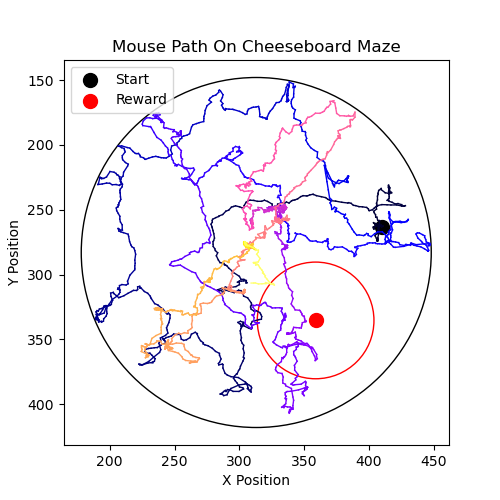

In [361]:
df = pd.read_hdf(filename) # Load HDF5 file
directory = os.path.dirname(filename)
timestamps_path = Path(directory,'timeStamps.csv')
if timestamps_path.exists():
    timestamps = pd.read_csv(timestamps_path)
    frame_rate = round(1/(np.mean(np.diff(timestamps.iloc[:,1]))/1000))  # fps
    print(f'Acquisition with DAQ, frame rate = {frame_rate} fps')
else:
    frame_rate = 16  # fps /!\ CHANGE ACCORDING TO YOUR DATA
    print(f'Acquisition with Webcam, frame rate = {frame_rate} fps')

if 'LongTermMemory' in filename:
    REWARD= True
else: 
    REWARD = False

# Define parameters
pixel_to_cm = 2.25  
reward_zone = 20 * pixel_to_cm if "Training" in filename else 20 * pixel_to_cm  # 8 cm for training, 20 cm for test
table_center_x, table_center_y = 313, 283  # Center of the cheeseboard table on the video
table_radius = 270 / 2
min_stay_at_reward = 5 * frame_rate  # 5 seconds

# Define functions
def calculate_relative_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_distance_run(x_coords, y_coords):
    distances = np.sqrt(np.diff(x_coords) ** 2 + np.diff(y_coords) ** 2)
    for i in range(1, len(distances) - 1):
        if np.isnan(distances[i]):
            neighbors = [distances[i-1], distances[i+1]]
            distances[i] = np.mean([x for x in neighbors if not np.isnan(x)])
    total_distance_cm = np.nansum(distances) / pixel_to_cm  # Convert to cm
    return total_distance_cm, distances

def find_long_non_nan_sequences(arr, min_length=100):
    mask = ~np.isnan(arr)  # True for non-NaN values
    diff = np.diff(np.concatenate(([0], mask.astype(int), [0])))  # Add padding to detect edges
    starts = np.where(diff == 1)[0]  # Where a sequence starts
    ends = np.where(diff == -1)[0]   # Where a sequence ends
    sequences = [arr[start:end] for start, end in zip(starts, ends) if (end - start) > min_length]
    return sequences

def remove_outliers_median_filter(data, window=1):
    data = np.array(data, dtype=float)  # Ensure NumPy array with float type
    filtered_data = np.copy(data)  # Copy to avoid modifying original data
    half_window = window // 2
    for i in range(len(data)):
        # Define window range, ensuring it doesn't exceed bounds
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        # Extract local values in window
        local_values = data[start:end]
        # Check if the window contains at least one non-NaN value
        if np.all(np.isnan(local_values)):
            median_value = np.nan  # Keep NaN if no valid numbers
        else:
            median_value = np.nanmedian(local_values)  # Compute median ignoring NaNs
        # Replace only if the current value is not NaN
        if not np.isnan(data[i]):
            filtered_data[i] = median_value
    return filtered_data

def replace_high_speed_points_with_nan(x, y, speed_threshold):
    x = np.array(x, dtype='float')
    y = np.array(y, dtype='float')
    # Compute speed between consecutive points
    dx = np.diff(x)
    dy = np.diff(y)
    speeds = np.sqrt(dx**2 + dy**2)
    # Create mask for speed exceeding threshold
    high_speed_mask = speeds > speed_threshold
    # We mark i+1 as NaN if speed between them is too high
    x_out = x.copy()
    y_out = y.copy()
    for i in range(len(high_speed_mask)):
        if high_speed_mask[i]:
            # Only mark the faster of the two points
            if i > 0 and i < len(x) - 1:
                if speeds[i] > speeds[i - 1]:
                    x_out[i + 1] = np.nan
                    y_out[i + 1] = np.nan
                else:
                    x_out[i] = np.nan
                    y_out[i] = np.nan
    return x_out, y_out

def interpolate_2d_path(x, y, kind='linear', fill='extrapolate'):
    x = np.array(x, dtype='float')
    y = np.array(y, dtype='float')
    indices = np.arange(len(x))
    valid_mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(valid_mask) < 2:
        raise ValueError("Not enough valid points to interpolate/extrapolate.")
    interp_x = interp1d(indices[valid_mask], x[valid_mask], kind=kind, fill_value=fill, bounds_error=False)
    interp_y = interp1d(indices[valid_mask], y[valid_mask], kind=kind, fill_value=fill, bounds_error=False)
    x_filled = x.copy()
    y_filled = y.copy()
    nan_mask = np.isnan(x) | np.isnan(y)
    x_filled[nan_mask] = interp_x(indices[nan_mask])
    y_filled[nan_mask] = interp_y(indices[nan_mask])
    return x_filled, y_filled

def limit_speed(x, y, max_speed):
    x = x.copy()
    y = y.copy()    
    for i in range(len(x)-1):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        dist = np.sqrt(dx**2 + dy**2)
        if dist > max_speed:
            # Number of intermediate points needed
            num_points = int(np.ceil(dist / max_speed))
            # Linear interpolate points between i and i+1
            xs = np.linspace(x[i], x[i+1], num_points+1)
            ys = np.linspace(y[i], y[i+1], num_points+1)
            # Replace original points with new interpolated points except first one
            x = np.insert(x, i+1, xs[1:-1])
            y = np.insert(y, i+1, ys[1:-1])
    return x, y

def remove_short_sequences(arr, max_len=10):
    arr = np.array(arr, dtype='float')
    result = arr.copy()
    is_value = ~np.isnan(arr)
    i = 0
    while i < len(arr):
        if is_value[i]:
            start = i
            while i < len(arr) and is_value[i]:
                i += 1
            end = i
            seq_len = end - start
            # Check if surrounded by NaNs and short enough
            if seq_len <= max_len:
                left_nan = (start == 0) or np.isnan(arr[start - 1])
                right_nan = (end == len(arr)) or np.isnan(arr[end])  # safe for edge
                if left_nan and right_nan:
                    result[start:end] = np.nan
        else:
            i += 1
    return result

# Remove uncertain location predictions (likelihood < 0.9)
df.iloc[:, 0] = df.apply(lambda row: row.iloc[0] if row.iloc[-1] > 0.9 else np.nan, axis=1)
df.iloc[:, 1] = df.apply(lambda row: row.iloc[1] if row.iloc[-1] > 0.9 else np.nan, axis=1)

X = df.iloc[:, 0]
Y = df.iloc[:, 1]

# Separate the individual's positions into x and y coordinates
individual_xO= np.array(X.values)
individual_yO = np.array(Y.values)

# Define when the mouse is on the cheeseboard (start)
for i, x in enumerate(individual_xO):
    y = individual_yO[i]
    if calculate_relative_distance(x, y, table_center_x, table_center_y) >= table_radius:
        individual_xO[i] = np.nan
        individual_yO[i] = np.nan

individual_xOO = remove_short_sequences(individual_xO, max_len=3)
individual_yOO = remove_short_sequences(individual_yO, max_len=3)

x_start = find_long_non_nan_sequences(individual_xOO)[0][0] # first value of the first long non nan sequence
y_start = find_long_non_nan_sequences(individual_yOO)[0][0] # first value of the first long non nan sequence

start_frame = np.where(individual_xOO == x_start)[0].item()
individual_xOO[:start_frame]=np.nan # remove any path before the real start
individual_yOO[:start_frame]=np.nan # remove any path before the real start

individual_x1, individual_y1 = replace_high_speed_points_with_nan(individual_xOO, individual_yOO, speed_threshold=8)

for i in range(len(individual_x1)-1, 0, -1): # Find the last non-NaN value which is not isolated
    if not np.isnan(individual_x1[i]) and not np.isnan(individual_x1[i-1]):
        last_frame = i
        break

individual_x2, individual_y2 = interpolate_2d_path(individual_x1[start_frame:last_frame], individual_y1[start_frame:last_frame], kind='nearest')
individual_x3, individual_y3 = limit_speed(individual_x2, individual_y2, max_speed=8)

individual_x = np.concatenate((individual_x1[:start_frame], individual_x3))
individual_y = np.concatenate((individual_y1[:start_frame], individual_y3))


if timestamps_path.exists():
    start_time = timestamps.iloc[start_frame,1].item() / 1000
    end_time = timestamps.iloc[-1,1].item() / 1000
    duration_trial = end_time - start_time
else:
    duration_trial = (last_frame - start_frame) / frame_rate
print(f'Total trial duration: {round(duration_trial)} sec')

total_distance, distances = calculate_distance_run(individual_x[start_frame:last_frame], individual_y[start_frame:last_frame])
print(f"Total distance run: {round(total_distance)} cm")
print(f"Average speed: {round(np.nanmean(distances)/pixel_to_cm*frame_rate,2)} cm/s")

# Remove NaN values 
individual_x_filt = individual_x[~np.isnan(individual_x)]        
individual_y_filt = individual_y[~np.isnan(individual_y)]

if REWARD:
    with open("//10.69.168.1/crnldata/forgetting/Aurelie/MiniscopeOE_data/Reward_position.txt", "r") as file:
        text = file.read()  
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    reward_x, reward_y = map(float, numbers)
    
    # Define when the mouse eats the reward (end)
    found_reward_frame = np.nan
    consecutive_count = 0
    for i, (x, y) in enumerate(zip(individual_x, individual_y)):
        if calculate_relative_distance(x, y, reward_x, reward_y) <= reward_zone:
            consecutive_count += 1
        else:
            consecutive_count = 0  
        if consecutive_count > min_stay_at_reward:
            found_reward_frame = (i - min_stay_at_reward)
            break
        
    if timestamps_path.exists():
        found_reward_time = timestamps.iloc[found_reward_frame,1].item() / 1000
        latency = (found_reward_time - start_time)
    else:
        latency = (found_reward_frame - start_frame) / frame_rate
    print(f'Latency to reward: {round(latency)} sec')

    # Define the time spent inside the reward zone
    time_spent_in_zone = 0

    for i, (x, y) in enumerate(zip(individual_x, individual_y)):
        if calculate_relative_distance(x, y, reward_x, reward_y) <= reward_zone:
            time_spent_in_zone += 1

    time_spent_in_zone = time_spent_in_zone / frame_rate
    print(f'Time spent in reward zone: {round(time_spent_in_zone)} sec ({round(time_spent_in_zone / duration_trial * 100)} %)')


    # Define the number of times the mouse enters the reward zone
    enter_reward_zone = 0
    consecutive_count = 0
    for i, (x, y) in enumerate(zip(individual_x_filt, individual_y_filt)):
        if calculate_relative_distance(x, y, reward_x, reward_y) <= reward_zone:
            if consecutive_count == 0:
                enter_reward_zone += 1
                consecutive_count = 1
        else:
            consecutive_count = 0   

    print(f'Crossings in the reward zone: {enter_reward_zone}')

    distance_to_reward, distances_to_reward = calculate_distance_run(individual_x[start_frame:found_reward_frame], individual_y[start_frame:found_reward_frame])
    print(f'Distance run to reward: {round(distance_to_reward)} cm')

    print(f"Crossings per meter: {round(enter_reward_zone / (round(distance_to_reward) / 100), 2)}")
    print(f"Average speed before reward: {round(np.nanmean(distances_to_reward)/pixel_to_cm*frame_rate,2)} cm/s")

# Create the plot
fig, ax = plt.subplots(figsize=(5, 5)) 

# Plot individual positions over time
cmap = plt.get_cmap('gnuplot2')
norm = plt.Normalize(vmin=0, vmax=len(individual_x))

for i in range(1, len(individual_x_filt)):
    ax.plot(individual_x[i-1:i+1], individual_y[i-1:i+1], color=cmap(norm(i)), linewidth=1)

#plt.plot(individual_x, individual_y, label="Individual's Path", color='b')

plt.scatter(x_start, y_start, color='black', s=100, label='Start')
# Draw cheeseboard circle
table_circle = plt.Circle((table_center_x, table_center_y), table_radius, color='k', fill=False)
plt.gca().add_patch(table_circle) 

if REWARD:
    plt.scatter(reward_x, reward_y, color='red', s=100, label='Reward')
    # Draw reward zone circle
    reward_circle = plt.Circle((reward_x, reward_y), reward_zone, color='r', fill=False)
    plt.gca().add_patch(reward_circle)  

# Add labels and title
ax.set_aspect('equal')
ax.invert_yaxis()
plt.title(f'Mouse Path On Cheeseboard Maze')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend(loc='upper left')
plt.show()

Test if the mouse as learned the location (to perform on MemoryTest days)

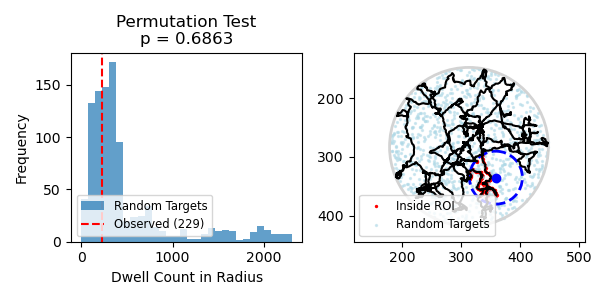

In [397]:
def test_dwell_time_significance(
    x, y, target_location, radius=8, table_radius=60, table_center=(0, 0),
    n_permutations=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    x = np.asarray(x)
    y = np.asarray(y)
    target_location = np.asarray(target_location)
    center_x, center_y = table_center
    # Observed dwell time
    dist_to_target = np.sqrt((x - target_location[0])**2 + (y - target_location[1])**2)
    observed_dwell = np.sum(dist_to_target <= radius)
    # Random surrogate target locations centered on the actual table
    random_dwell_times = []
    surrogate_targets = []
    for _ in range(n_permutations):
        r = table_radius * np.sqrt(np.random.rand())
        theta = 2 * np.pi * np.random.rand()
        rx = center_x + r * np.cos(theta)
        ry = center_y + r * np.sin(theta)
        surrogate_targets.append([rx, ry])
        dist = np.sqrt((x - rx)**2 + (y - ry)**2)
        dwell = np.sum(dist <= radius)
        random_dwell_times.append(dwell)
    surrogate_targets = np.array(surrogate_targets)
    random_dwell_times = np.array(random_dwell_times)
    # p-value
    p_value = (np.sum(random_dwell_times >= observed_dwell) + 1) / (n_permutations + 1)
    # Plotting
    plt.figure(figsize=(6, 3))
    # Histogram of permutation results
    plt.subplot(1, 2, 1)
    plt.hist(random_dwell_times, bins=30, alpha=0.7, label='Random Targets')
    plt.axvline(observed_dwell, color='red', linestyle='--', label=f'Observed ({observed_dwell})')
    plt.title(f'Permutation Test\np = {p_value:.4f}')
    plt.xlabel('Dwell Count in Radius')
    plt.ylabel('Frequency')
    plt.legend(loc='lower left', fontsize='small')
    # Path and random targets
    plt.subplot(1, 2, 2)
    plt.plot(x, y, '-', color='black', alpha=1)
    plt.scatter(x[dist_to_target <= radius], y[dist_to_target <= radius], color='red', s=2, label='Inside ROI')
    # Add surrogate targets
    plt.scatter(surrogate_targets[:, 0], surrogate_targets[:, 1], s=2, color='lightblue', alpha=0.5, label='Random Targets')
    # Draw table and ROI around target
    plt.gca().add_artist(plt.Circle(table_center, table_radius, fill=False, color='lightgray', lw=2))
    plt.gca().add_artist(plt.Circle(target_location, radius, fill=False, color='blue', linestyle='--', lw=2))
    plt.scatter(*target_location, color='blue', zorder=5)
    plt.axis('equal')
    plt.tight_layout()
    plt.gca().invert_yaxis()   # <--- This inverts the y-axis
    plt.legend(loc='lower left', fontsize='small')
    plt.show()
    return observed_dwell, random_dwell_times, p_value

observed_dwell, random_dwell_times, p_value= test_dwell_time_significance(
    individual_x, individual_y,
    target_location=[reward_x, reward_y],
    radius=reward_zone,
    table_radius=table_radius,
    table_center=(table_center_x, table_center_y),
    n_permutations=1000,
    seed=None
)